In [1]:
import os.path
import sys
import datetime

import numpy as np
import matplotlib.pyplot as plt

import dnormtomo.channelspace
import dnormtomo.bistates
import dnormtomo.util

import qutip

import tomographer
import tomographer.jpyutil
import tomographer.querrorbars

# to save & load computation results
try:
    import cPickle as pickle
except:
    import pickle

# interact with plots in notebook
%matplotlib notebook

In [2]:
#
# number of outcomes per Pauli pairs
#
NumSamplesPerSetting = 500
# Pauli measurement settings on one system
PauliMeasSettings = [
    [
        dnormtomo.util.projpauli(i, s)
        for s in [1, -1]
    ]
    for i in [1, 2, 3]
]
# simulate the measurements
sigmareal_X = qutip.Qobj(np.array([[ 0.6, 0.01], [0.01, 0.4]]))
Ereal_XY = qutip.Qobj(np.array([[ 0.95, 0, 0, 0.95],
                                [ 0, 0.05, 0, 0],
                                [ 0, 0,    0, 0],
                                [ 0.95, 0, 0, 1],
                               ]), dims=[[2,2],[2,2]])
def simulate_measurements():
    d = dnormtomo.util.simulate_process_measurements(sigmareal_X, Ereal_XY, PauliMeasSettings, PauliMeasSettings,
                                                     NumSamplesPerSetting)
    
    with open('meas_data.dat', 'wb') as f:
        pickle.dump(d, f)
        
    return d

#
# Only simulate the measurements once. After that, use the same data when comparing methods!!
#
if not os.path.exists('meas_data.dat'):
    d = simulate_measurements()
else:
    with open('meas_data.dat', 'rb') as f:
        d = pickle.load(f)

#print(d.__dict__) # should print Emn, Nm

In [14]:
#
# Stuff for the analysis, later
#
def print_report(r):
    print("Calculation ran for {!s} seconds".format(datetime.timedelta(seconds=r['elapsed_seconds'])))
    print(r['final_report_runs'])

def do_analysis(r, name, plots=False):
    final_histogram = r['final_histogram']
    analysis = tomographer.querrorbars.HistogramAnalysis(final_histogram, threshold_fraction=1e-3)
    fitparams = analysis.printFitParameters()
    analysis.printQuantumErrorBars()
    
    p1 = None
    p2 = None
    
    if plots:
        p1 = analysis.plot(show_plot=False) # linear scale
        p1.ax.set_title("Distribution of the diamond norm: " + name)
        p1.ax.set_xlabel('Diamond Norm distance to the identity channel')
        p1.show()

        p2 = analysis.plot(log_scale=True, show_plot=False) # log scale
        p2.ax.set_title("Distribution of the diamond norm: " + name)
        p2.ax.set_xlabel('Diamond Norm distance to the identity channel')
        p2.show()
    
    return {'r': r, 'name': name, 'analysis': analysis, 'fitparams': fitparams, 'p1': p1, 'p2': p2}


# Naive method

In [5]:
r_naive = None
with tomographer.jpyutil.RandWalkProgressBar() as prg:
    r_naive = dnormtomo.bistates.run(
        dimX=2, dimY=2, Emn=d.Emn, Nm=np.array(d.Nm),
        hist_params=tomographer.HistogramParams(0, 0.2, 50),
        mhrw_params=tomographer.MHRWParams(0.008, 125, 2048, 32768),
        progress_fn=prg.progress_fn
        )
    prg.displayFinalInfo(r_naive['final_report_runs'])
print_report(r_naive)

Calculation ran for 0:09:46.346956 seconds

                                        Final Report of Runs                                        
----------------------------------------------------------------------------------------------------
	step            : step_size=0.008
	# iter. / sweep = 125
	# therm. sweeps = 2048
	# run sweeps    = 32768
#0: 0|        ....-+x%###xo+--........                  |0.2                   [accept ratio = 0.32]
    error bars: 49 converged / 1 maybe (1 isolated) / 0 not converged
#1: 0|       .....-+x####xo+--......                    |0.2                   [accept ratio = 0.30]
    error bars: 49 converged / 1 maybe (1 isolated) / 0 not converged
----------------------------------------------------------------------------------------------------




In [15]:
a_naive = do_analysis(r_naive, 'Naive')

Fit parameters:
          a2 = 2.45928e-17
          a1 = 498.066
           m = 33.9453
           c = 128.65
Quantum Error Bars:
          f0 = 0.06815
       Delta = 0.01654
       gamma = 0.001339



# Channel-space methods

In [7]:
# we need to encode the input state in the POVM effects

sigmareal_X_sqrtm_eyeY = np.kron(sigmareal_X.sqrtm().data.toarray(), np.eye(2))
Emn_for_channelspace = [
    np.dot(np.dot(sigmareal_X_sqrtm_eyeY, E), sigmareal_X_sqrtm_eyeY)
    for E in d.Emn
]

## Channel-space method with $e^{iH}$ jumps

In [8]:
r_eiH = None
with tomographer.jpyutil.RandWalkProgressBar() as prg:
    r_eiH = dnormtomo.channelspace.run(
        dimX=2, dimY=2, Emn=Emn_for_channelspace, Nm=np.array(d.Nm),
        hist_params=tomographer.HistogramParams(0, 0.2, 50),
        channel_walker_jump_mode=dnormtomo.channelspace.RandHermExp,
        mhrw_params=tomographer.MHRWParams(0.01, 100, 2048, 32768),
        progress_fn=prg.progress_fn
        )
    prg.displayFinalInfo(r_eiH['final_report_runs'])
print_report(r_eiH)

Calculation ran for 0:17:19.887065 seconds

                                        Final Report of Runs                                        
----------------------------------------------------------------------------------------------------
	step            : step_size=0.01
	# iter. / sweep = 100
	# therm. sweeps = 2048
	# run sweeps    = 32768
#0: 0|        ....-+x%###%x+--.........                 |0.2                   [accept ratio = 0.31]
    error bars: 50 converged / 0 maybe (0 isolated) / 0 not converged
#1: 0|        ....-+x%###%x+--........                  |0.2                   [accept ratio = 0.31]
    error bars: 50 converged / 0 maybe (0 isolated) / 0 not converged
----------------------------------------------------------------------------------------------------




In [16]:
a_eiH = do_analysis(r_eiH, 'e^{iH} jumps')

Fit parameters:
          a2 = 23.038
          a1 = 490.024
           m = 33.8752
           c = 128.014
Quantum Error Bars:
          f0 = 0.06869
       Delta = 0.01664
       gamma = 0.001335



## Channel-space method with "elementary-rotation" jumps

In [10]:
r_elr = None
with tomographer.jpyutil.RandWalkProgressBar() as prg:
    r_elr = dnormtomo.channelspace.run(
        dimX=2, dimY=2, Emn=Emn_for_channelspace, Nm=np.array(d.Nm),
        hist_params=tomographer.UniformBinsHistogramParams(0, 0.2, 50),
        channel_walker_jump_mode=dnormtomo.channelspace.ElemRotations,
        mhrw_params=tomographer.MHRWParams(0.02, 50, 2048, 32768),
        progress_fn=prg.progress_fn
        )
    prg.displayFinalInfo(r_elr['final_report_runs'])
print_report(r_elr)

Calculation ran for 0:14:01.367711 seconds

                                        Final Report of Runs                                        
----------------------------------------------------------------------------------------------------
	step            : step_size=0.02
	# iter. / sweep = 50
	# therm. sweeps = 2048
	# run sweeps    = 32768
#0: 0|        ....-+x%###xo+--.......   .               |0.2                   [accept ratio = 0.24]
    error bars: 50 converged / 0 maybe (0 isolated) / 0 not converged
#1: 0|        ....-+x%###%o+--........   .              |0.2                   [accept ratio = 0.24]
    error bars: 49 converged / 1 maybe (1 isolated) / 0 not converged
----------------------------------------------------------------------------------------------------




In [17]:
a_elr = do_analysis(r_elr, '"elem. rotation" jumps')

Fit parameters:
          a2 = 69.437
          a1 = 472.822
           m = 33.0936
           c = 124.953
Quantum Error Bars:
          f0 = 0.06861
       Delta = 0.0167
       gamma = 0.001329



# Grand comparison of the three methods

<IPython.core.display.Javascript object>


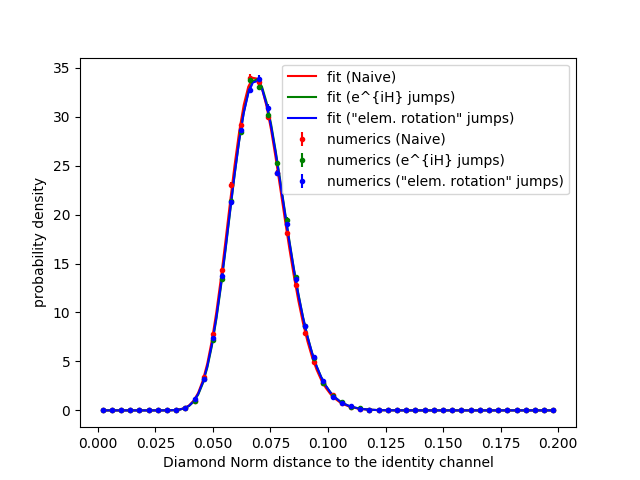

<IPython.core.display.Javascript object>


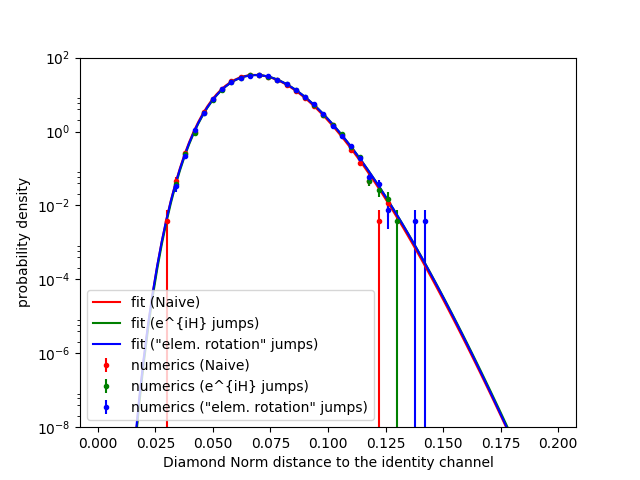

In [21]:
def do_comparison_plot(alist, log_scale=False):

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_xlabel('Diamond Norm distance to the identity channel')
    ax.set_ylabel('probability density')
    if log_scale:
        ax.set_yscale('log')
    
    clist = 'rgbcmyk'
        
    for i in range(len(alist)):
        a = alist[i]
        r = a['r']
        h = r['final_histogram'].normalized()
        c = clist[i%len(clist)]
        f = h.values_center
        analysis = a['analysis']
        
        ax.errorbar(x=f, y=h.bins, yerr=h.delta, c=c, fmt='.', label='numerics ({})'.format(a['name']))
        flist = np.linspace(np.min(f), np.max(f), 100)
        ax.plot(flist, np.exp(analysis.fit_fn(analysis.ftox(flist), *analysis.fit_params)), c=c,
                label='fit ({})'.format(a['name']))
    
    if log_scale:
        ax.set_ylim([1e-8, 1e2])
        
    plt.legend()
    plt.show()
    
do_comparison_plot([a_naive, a_eiH, a_elr])

do_comparison_plot([a_naive, a_eiH, a_elr], log_scale=True)

Fit parameters:
          a2 = 675.607
          a1 = 132.257
           m = 0.599334
           p = 3.12187
           c = 28.778


<IPython.core.display.Javascript object>


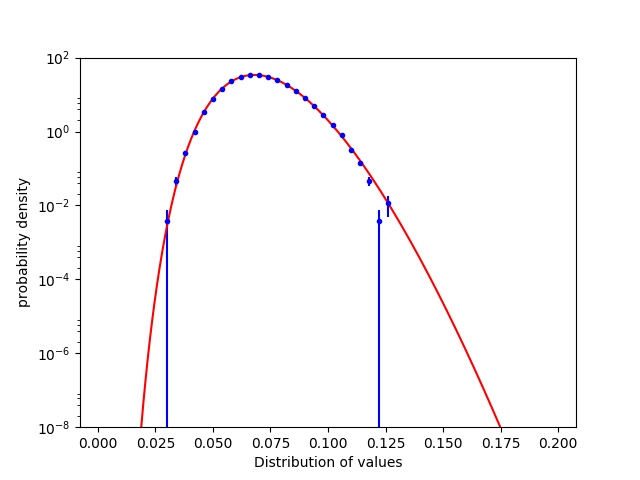

In [24]:
def fit_fn_n2(x, a2, a1, m, p, c):
    return -a2*np.square(x)-a1*x - m*np.power(-np.log(x), p) + c

r = r_naive
a = tomographer.querrorbars.HistogramAnalysis(
    r['final_histogram'], fit_fn=fit_fn_n2,
    bounds=((0,-np.inf,0,-np.inf,0), np.inf),
    p0=(1,1,1,3,50), maxfev=100000,
)
a.printFitParameters()
dp = a.plot(plot_deskewed_gaussian=False, show_plot=False, log_scale=True)
dp.ax.set_ylim([1e-8, 1e2])
dp.show()
